#### Пример работы с кодом

In [4]:
# чтобы изменения в других файлах автоматически подгружались в импорты
%load_ext IPython.extensions.autoreload
%autoreload 2

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [5]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

from data import FinData
from preprocessing import train_valid_split, train_valid_test_split
from model import CatboostFinModel

In [6]:
data = FinData("../datasets/T_yandex_10min.csv", column_names={'Yandex open' : 'open', 
                                          'Yandex close' : 'close', 
                                          'Yandex high' : 'high', 
                                          'Yandex low' : 'low', 
                                          'Yandex volume' : 'volume'})

windows_ma = [2, 4, 6, 18, 30, 50, 1000] # здесь можно менять окна для признаков и пробовать другие
shifts_norms = [2, 3, 4, 5, 6]

data.insert_time_features()
data.make_binary_class_target()
data.insert_rolling_means(windows_ma)
data.insert_shifts_norms(shifts_norms)
data.insert_exp_rolling_means(windows_ma)

In [7]:
data.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'hours', 'day',
       'minute', 'direction', 'direction_binary', 'ma_2', 'close_normed_ma_2',
       'ma_4', 'close_normed_ma_4', 'ma_6', 'close_normed_ma_6', 'ma_18',
       'close_normed_ma_18', 'ma_30', 'close_normed_ma_30', 'ma_50',
       'close_normed_ma_50', 'ma_1000', 'close_normed_ma_1000',
       'close_norms_2', 'close_high_norms_2', 'high_norms_2', 'low_norms_2',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 'low_norms_3',
       'close_norms_4', 'close_high_norms_4', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'close_high_norms_5', 'high_norms_5', 'low_norms_5',
       'close_norms_6', 'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'ema_2', 'close_normed_ema_2', 'ema_4', 'close_normed_ema_4', 'ema_6',
       'close_normed_ema_6', 'ema_18', 'close_normed_ema_18', 'ema_30',
       'close_normed_ema_30', 'ema_50', 'close_normed_ema_50', 'ema_1000',
       'close_normed_ema_1000'],

In [8]:
numeric = ['high_norms_2', 'low_norms_2', 'close_norms_3', 'high_norms_3',
       'low_norms_3', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'high_norms_5', 'low_norms_5', 'close_norms_6',
       'high_norms_6', 'low_norms_6', 'close_normed_ma_2', 'close_normed_ma_4', 'close_normed_ma_6',
        'close_normed_ma_18', 'close_normed_ma_30', 'close_normed_ma_50', 'close_normed_ma_1000','close_normed_ema_2', 'close_normed_ema_4',
       'close_normed_ema_6', 'close_normed_ema_18',
       'close_normed_ema_30', 'close_normed_ema_50',
       'close_normed_ema_1000']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

data.restrict_time_down(2024, 11, 1)

In [9]:
data.check_stationarity(columns=numeric)

Столбец: close_normed_ma_1000
  Нестационарность обнаружена в следующих тестах:
    - Phillips-Perron (p-value: 0.31410)
    - ADF (p-value: 0.33725)
Столбец: close_normed_ema_1000
  Нестационарность обнаружена в следующих тестах:
    - Phillips-Perron (p-value: 0.14175)
    - ADF (p-value: 0.14001)


In [10]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [11]:
model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.6127031	test: 0.6010101	best: 0.6010101 (0)	total: 175ms	remaining: 29m 7s
100:	learn: 0.6221566	test: 0.6060606	best: 0.6212121 (6)	total: 557ms	remaining: 54.6s
200:	learn: 0.6265879	test: 0.6161616	best: 0.6212121 (6)	total: 930ms	remaining: 45.4s
300:	learn: 0.6330871	test: 0.6060606	best: 0.6212121 (6)	total: 1.28s	remaining: 41.3s
400:	learn: 0.6413589	test: 0.6111111	best: 0.6212121 (6)	total: 1.63s	remaining: 38.9s
500:	learn: 0.6463811	test: 0.6010101	best: 0.6212121 (6)	total: 2s	remaining: 38s
600:	learn: 0.6487445	test: 0.6060606	best: 0.6212121 (6)	total: 2.45s	remaining: 38.4s
700:	learn: 0.6528804	test: 0.6010101	best: 0.6212121 (6)	total: 3.1s	remaining: 41.1s
800:	learn: 0.6608567	test: 0.6111111	best: 0.6212121 (6)	total: 3.63s	remaining: 41.6s
900:	learn: 0.6694239	test: 0.6161616	best: 0.6212121 (6)	total: 4.15s	remaining: 41.9s
1000:	learn: 0.6756278	test: 0.6161616	best: 0.6212121 (6)	total: 4.52s	remaining: 40.7s
1100:	learn: 0.6815362	test: 0.6161616

In [13]:
model.print_constant_accuracy(y_val)

Точность константного предсказания 0.5404040404040404


In [14]:
model.print_feature_importances()

1.7824318467553084 close_normed_ema_30
2.1807500048470563 close_normed_ema_6
2.627621526423521 close_normed_ema_50
2.815652826409346 high_norms_4
2.838130578717063 close_normed_ma_6
2.9491839607331434 low_norms_5
3.125688580640193 low_norms_4
3.1965334239350227 close_normed_ma_30
3.2165759369041105 close_normed_ma_50
3.2451320500409744 close_normed_ema_2
3.291860488209803 close_normed_ema_18
3.6000441461752577 close_normed_ma_1000
3.6157556630546357 high_norms_5
3.6225404256555227 low_norms_3
3.6757621879257916 close_normed_ema_4
3.9744655655677428 high_norms_6
3.9786296750137806 close_normed_ema_1000
3.9813002844248087 close_norms_5
4.111627869195672 close_norms_6
4.125186582936585 high_norms_3
4.198650480318909 close_normed_ma_18
4.306762530770045 high_norms_2
4.327834530769428 low_norms_2
4.481606813844396 close_norms_3
4.759212323668825 low_norms_6
4.988365608059392 close_normed_ma_2
6.982694089003653 close_normed_ma_4


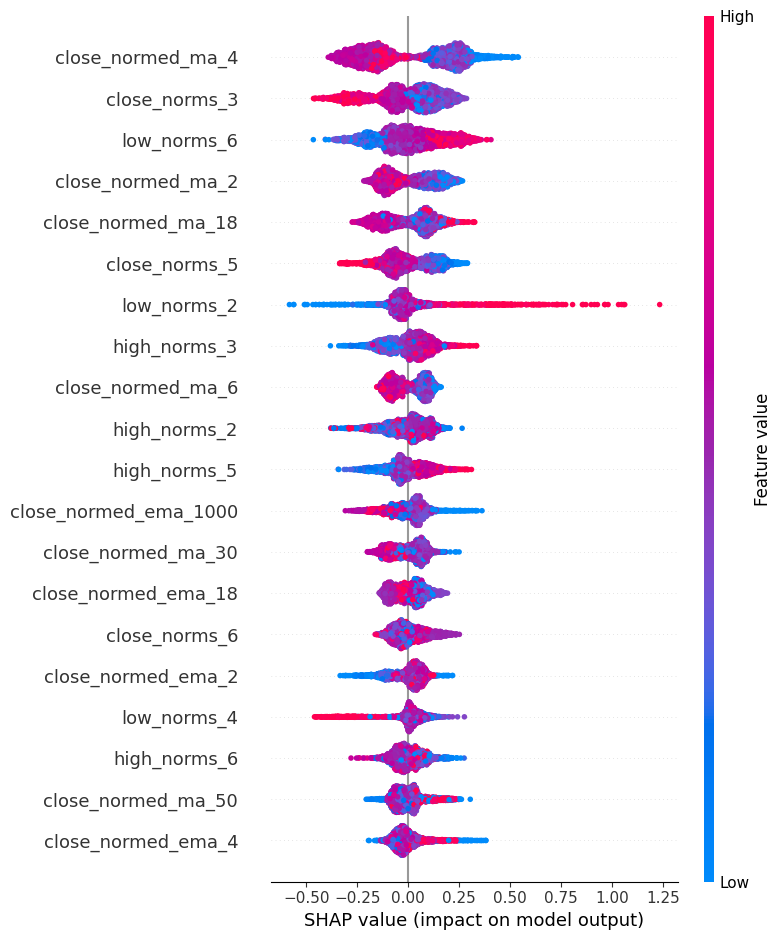

In [15]:
model.visualise_shap_values()

#### Теперь попробуем со всеми признаками

In [14]:
numeric = ['ma_2', 'close_normed_ma_2',
       'ma_4', 'close_normed_ma_4', 'ma_6', 'close_normed_ma_6', 'ma_18',
       'close_normed_ma_18', 'ma_30', 'close_normed_ma_30', 'ma_50',
       'close_normed_ma_50', 'ma_1000', 'close_normed_ma_1000',
       'close_norms_2', 'close_high_norms_2', 'high_norms_2', 'low_norms_2',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 'low_norms_3',
       'close_norms_4', 'close_high_norms_4', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'close_high_norms_5', 'high_norms_5', 'low_norms_5',
       'close_norms_6', 'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'ema_2', 'close_normed_ema_2', 'ema_4', 'close_normed_ema_4', 'ema_6',
       'close_normed_ema_6', 'ema_18', 'close_normed_ema_18', 'ema_30',
       'close_normed_ema_30', 'ema_50', 'close_normed_ema_50', 'ema_1000',
       'close_normed_ema_1000']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100,
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

data.restrict_time_down(2024, 11, 1)

In [15]:
data.check_stationarity_pp(columns=numeric)

Столбец: ma_2 нестационарен, p_value: 0.7850210619128686
Столбец: ma_4 нестационарен, p_value: 0.7863740482190487
Столбец: ma_6 нестационарен, p_value: 0.7912562949411072
Столбец: ma_18 нестационарен, p_value: 0.8200348863337877
Столбец: ma_30 нестационарен, p_value: 0.8458454314464904
Столбец: ma_50 нестационарен, p_value: 0.8773552848606169
Столбец: ma_1000 нестационарен, p_value: 0.9965903024822096
Столбец: close_normed_ma_1000 нестационарен, p_value: 0.31410489959092963
Столбец: ema_2 нестационарен, p_value: 0.7825376910569339
Столбец: ema_4 нестационарен, p_value: 0.791170509838685
Столбец: ema_6 нестационарен, p_value: 0.7980989476469482
Столбец: ema_18 нестационарен, p_value: 0.8361909479521102
Столбец: ema_30 нестационарен, p_value: 0.8643490667672051
Столбец: ema_50 нестационарен, p_value: 0.8944621182115975
Столбец: ema_1000 нестационарен, p_value: 0.997402181466267
Столбец: close_normed_ema_1000 нестационарен, p_value: 0.14174870940665457


In [21]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.6171344	test: 0.5909091	best: 0.5909091 (0)	total: 28.8ms	remaining: 4m 48s
100:	learn: 0.6230428	test: 0.6060606	best: 0.6161616 (15)	total: 2.5s	remaining: 4m 5s
200:	learn: 0.6251108	test: 0.6060606	best: 0.6161616 (15)	total: 3.78s	remaining: 3m 4s
300:	learn: 0.6339734	test: 0.6010101	best: 0.6161616 (15)	total: 4.86s	remaining: 2m 36s
400:	learn: 0.6443131	test: 0.5909091	best: 0.6161616 (15)	total: 6.01s	remaining: 2m 23s
500:	learn: 0.6511078	test: 0.5858586	best: 0.6161616 (15)	total: 8.84s	remaining: 2m 47s
600:	learn: 0.6587888	test: 0.5909091	best: 0.6161616 (15)	total: 10.1s	remaining: 2m 38s
700:	learn: 0.6649926	test: 0.6010101	best: 0.6161616 (15)	total: 11s	remaining: 2m 25s
800:	learn: 0.6697194	test: 0.6111111	best: 0.6161616 (15)	total: 11.9s	remaining: 2m 17s
900:	learn: 0.6732644	test: 0.6060606	best: 0.6161616 (15)	total: 12.8s	remaining: 2m 8s
1000:	learn: 0.6774003	test: 0.6060606	best: 0.6161616 (15)	total: 13.5s	remaining: 2m 1s
1100:	learn: 0.682

In [24]:
model.print_feature_importances()

0.0 close_normed_ema_1000
0.0 ema_6
0.0 ema_4
0.0 close_high_norms_6
0.0 close_norms_5
0.0 high_norms_4
0.0 ma_18
0.0 low_norms_2
0.0 close_high_norms_2
0.0 close_normed_ma_30
0.0 close_normed_ma_1000
0.0 ma_1000
0.012968965977198179 close_norms_2
0.025044888967240046 close_high_norms_4
0.05088865402599033 ema_18
0.07769465825368278 high_norms_6
0.09776316963732098 close_normed_ema_4
0.1559274438355818 ma_30
0.2304441472196421 ema_50
0.2378867328563111 close_norms_4
0.3201013114938197 ma_6
0.34481161952366346 ma_4
0.35916753611026053 ma_2
0.4383683802345155 low_norms_4
0.5190263009774745 close_high_norms_3
0.5422931614232667 close_high_norms_5
0.6422748403004903 close_normed_ema_2
0.6621163020104597 ema_2
0.7705118391864373 close_normed_ema_50
0.9102124384285486 ema_1000
0.9905738025783333 ema_30
1.1054687103465244 high_norms_2
1.1275428382266477 ma_50
1.23108047503126 close_norms_6
1.3217411004248387 low_norms_5
1.3675389984775816 close_normed_ma_18
1.4083614484960778 close_normed_ema

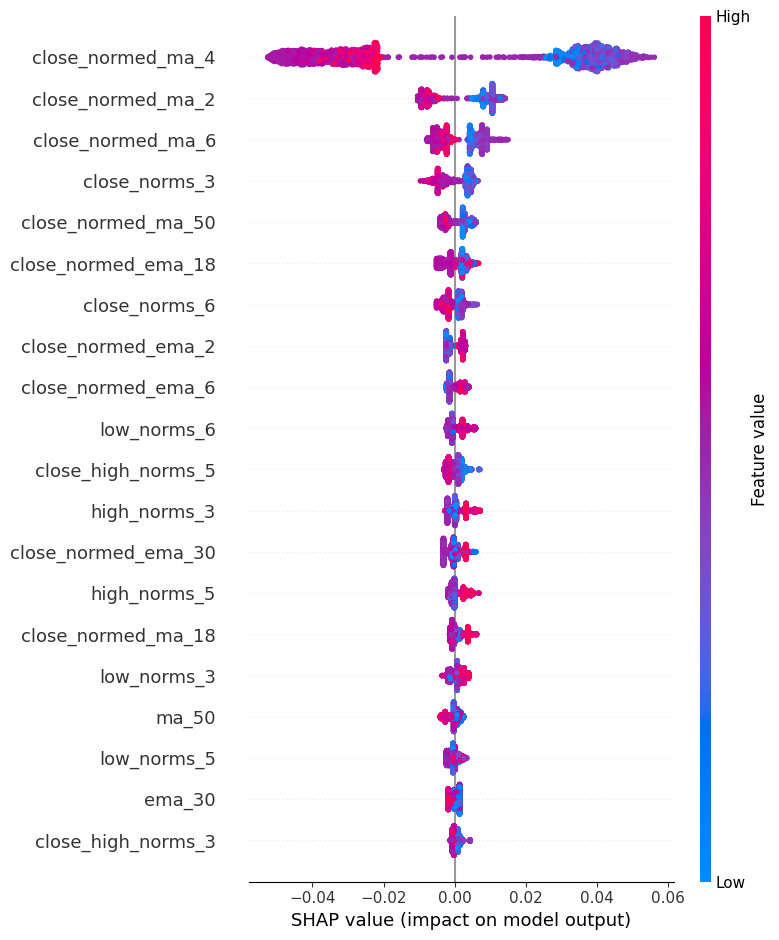

In [26]:
model.visualise_shap_values()

#### КСТАТИ РАЗНИЦА СУЩЕСТВЕННАЯ ОЧЕНЬ НУЖНО ПРЯМ ПОДУМАТЬ КАК ОТБИРАТЬ ПРИЗНАКИ 

In [109]:
data = FinData("../datasets/T_yandex_10min.csv", column_names={'Yandex open' : 'open', 
                                          'Yandex close' : 'close', 
                                          'Yandex high' : 'high', 
                                          'Yandex low' : 'low', 
                                          'Yandex volume' : 'volume'})

windows_ma = [2, 4, 6, 18, 30, 50, 1000] # здесь можно менять окна для признаков и пробовать другие
shifts_norms = [2, 3, 4, 5, 6]

data.insert_time_features()
data.make_binary_class_target()
data.insert_rolling_means(windows_ma)
data.insert_shifts_norms(shifts_norms)
data.insert_exp_rolling_means(windows_ma)

In [56]:
numeric = ['close_normed_ma_2','close_normed_ma_4','close_normed_ma_6', 
       'close_normed_ma_18','close_normed_ma_30', 
       'close_normed_ma_50','close_normed_ma_1000',
       'close_norms_2', 'close_high_norms_2', 'high_norms_2', 'low_norms_2',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 'low_norms_3',
       'close_norms_4', 'close_high_norms_4', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'close_high_norms_5', 'high_norms_5', 'low_norms_5',
       'close_norms_6', 'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'close_normed_ema_2','close_normed_ema_4', 
       'close_normed_ema_6', 'close_normed_ema_18',
       'close_normed_ema_30','close_normed_ema_50']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100,
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

data.restrict_time_down(2024, 11, 1)

In [57]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.6118168	test: 0.6111111	best: 0.6111111 (0)	total: 15ms	remaining: 2m 30s
100:	learn: 0.6233383	test: 0.6111111	best: 0.6363636 (1)	total: 622ms	remaining: 1m
200:	learn: 0.6286558	test: 0.6161616	best: 0.6363636 (1)	total: 1.42s	remaining: 1m 9s
300:	learn: 0.6363368	test: 0.5959596	best: 0.6363636 (1)	total: 2.25s	remaining: 1m 12s
400:	learn: 0.6410635	test: 0.5909091	best: 0.6363636 (1)	total: 2.97s	remaining: 1m 11s
500:	learn: 0.6466765	test: 0.5909091	best: 0.6363636 (1)	total: 4.01s	remaining: 1m 16s
600:	learn: 0.6514032	test: 0.5959596	best: 0.6363636 (1)	total: 4.71s	remaining: 1m 13s
700:	learn: 0.6549483	test: 0.6060606	best: 0.6363636 (1)	total: 5.44s	remaining: 1m 12s
800:	learn: 0.6605613	test: 0.6010101	best: 0.6363636 (1)	total: 6.26s	remaining: 1m 11s
900:	learn: 0.6697194	test: 0.6060606	best: 0.6363636 (1)	total: 6.88s	remaining: 1m 9s
1000:	learn: 0.6741507	test: 0.6161616	best: 0.6363636 (1)	total: 7.69s	remaining: 1m 9s
1100:	learn: 0.6782866	test: 0

In [58]:
model.print_feature_importances()

0.0 close_high_norms_4
0.0 close_normed_ema_18
0.0 close_normed_ema_6
0.0 close_normed_ema_4
0.0 close_normed_ema_2
0.0 low_norms_6
0.0 high_norms_6
0.0 close_high_norms_6
0.0 close_norms_6
0.0 low_norms_5
0.0 low_norms_4
0.0 high_norms_4
0.0 close_norms_4
0.0 low_norms_3
0.0 close_normed_ema_50
0.0 close_high_norms_2
0.0 close_norms_3
0.0 low_norms_2
0.0 high_norms_2
0.0 high_norms_3
0.0 close_norms_2
0.0 close_normed_ma_50
0.0 close_normed_ma_30
0.0 close_normed_ma_4
2.6154087524359175 close_normed_ma_1000
3.2021505271138078 close_norms_5
3.3874107753420835 close_normed_ema_30
3.4200235726453334 close_high_norms_5
3.569823734176301 high_norms_5
4.147998736797633 close_high_norms_3
5.267116446673021 close_normed_ma_18
17.229082293412063 close_normed_ma_6
57.16098516140383 close_normed_ma_2


Частично на глаз удалим часть незначимых признаков

In [59]:
numeric = ['close_normed_ma_2','close_normed_ma_4','close_normed_ma_6', 
       'close_normed_ma_18','close_normed_ma_30', 
       'close_normed_ma_50','close_normed_ma_1000',
       'close_norms_2', 'high_norms_2', 'low_norms_2',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 
       'close_norms_5', 'close_high_norms_5', 'high_norms_5', 
       'close_norms_6', 'close_high_norms_6', 
       'close_normed_ema_30']

In [60]:
cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100,
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

data.restrict_time_down(2024, 11, 1)

In [61]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.6144756	test: 0.6060606	best: 0.6060606 (0)	total: 9.48ms	remaining: 1m 34s
100:	learn: 0.6221566	test: 0.6010101	best: 0.6111111 (6)	total: 673ms	remaining: 1m 5s
200:	learn: 0.6262925	test: 0.6010101	best: 0.6111111 (6)	total: 1.74s	remaining: 1m 24s
300:	learn: 0.6313146	test: 0.6060606	best: 0.6111111 (6)	total: 2.39s	remaining: 1m 17s
400:	learn: 0.6363368	test: 0.5909091	best: 0.6111111 (6)	total: 2.9s	remaining: 1m 9s
500:	learn: 0.6401773	test: 0.5959596	best: 0.6111111 (6)	total: 3.7s	remaining: 1m 10s
600:	learn: 0.6437223	test: 0.5858586	best: 0.6111111 (6)	total: 4.29s	remaining: 1m 7s
700:	learn: 0.6511078	test: 0.5808081	best: 0.6111111 (6)	total: 4.88s	remaining: 1m 4s
800:	learn: 0.6558346	test: 0.5959596	best: 0.6111111 (6)	total: 5.47s	remaining: 1m 2s
900:	learn: 0.6623338	test: 0.5858586	best: 0.6111111 (6)	total: 6.26s	remaining: 1m 3s
1000:	learn: 0.6685377	test: 0.5858586	best: 0.6111111 (6)	total: 7.14s	remaining: 1m 4s
1100:	learn: 0.6768095	test: 0

#### Train valid test split по количеству тиков 

In [52]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary", utc=["utc"])

In [185]:
data = FinData("../datasets/T_yandex_10min.csv", column_names={'Yandex open' : 'open', 
                                          'Yandex close' : 'close', 
                                          'Yandex high' : 'high', 
                                          'Yandex low' : 'low', 
                                          'Yandex volume' : 'volume'})

windows_ma = [2, 4, 6, 18, 30, 50, 1000] # здесь можно менять окна для признаков и пробовать другие
shifts_norms = [2, 3, 4, 5, 6]

data.insert_time_features()
data.make_binary_class_target()
data.insert_rolling_means(windows_ma)
data.insert_shifts_norms(shifts_norms)
data.insert_exp_rolling_means(windows_ma)

In [198]:
numeric = ['high_norms_2', 'low_norms_2', 'close_norms_3', 'high_norms_3',
       'low_norms_3', 'high_norms_4', 'low_norms_4',
       'close_norms_5', 'high_norms_5', 'low_norms_5', 'close_norms_6',
       'high_norms_6', 'low_norms_6', 'close_normed_ma_2', 'close_normed_ma_4', 'close_normed_ma_6',
        'close_normed_ma_18', 'close_normed_ma_30', 'close_normed_ma_50', 'close_normed_ma_1000','close_normed_ema_2', 'close_normed_ema_4',
       'close_normed_ema_6', 'close_normed_ema_18',
       'close_normed_ema_30', 'close_normed_ema_50',
       'close_normed_ema_1000']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 3000}

data.restrict_time_down(2024, 11, 10)

In [199]:
test_start_data = dt.datetime(2024, 12, 5, 11, 0)

X_train, X_val, X_test, y_train, y_val, y_test = train_valid_test_split(data.df, 
                                                                        test_start_data=test_start_data, 
                                                                        numeric=numeric, 
                                                                        cat=cat, 
                                                                        test_ticks=100,
                                                                        val_ticks=200,
                                                                        target="direction_binary", utc=["utc"])

In [200]:
model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.6131934	test: 0.6000000	best: 0.6000000 (0)	total: 4.32ms	remaining: 43.2s
1:	learn: 0.6199400	test: 0.5900000	best: 0.6000000 (0)	total: 8.38ms	remaining: 41.9s
2:	learn: 0.6191904	test: 0.5800000	best: 0.6000000 (0)	total: 13.2ms	remaining: 44.1s
3:	learn: 0.6221889	test: 0.5950000	best: 0.6000000 (0)	total: 20.4ms	remaining: 50.9s
4:	learn: 0.6169415	test: 0.5950000	best: 0.6000000 (0)	total: 25.5ms	remaining: 50.9s
5:	learn: 0.6191904	test: 0.5900000	best: 0.6000000 (0)	total: 32ms	remaining: 53.3s
6:	learn: 0.6229385	test: 0.5850000	best: 0.6000000 (0)	total: 36.8ms	remaining: 52.6s
7:	learn: 0.6206897	test: 0.5950000	best: 0.6000000 (0)	total: 40.3ms	remaining: 50.4s
8:	learn: 0.6176912	test: 0.5950000	best: 0.6000000 (0)	total: 43.5ms	remaining: 48.3s
9:	learn: 0.6191904	test: 0.5950000	best: 0.6000000 (0)	total: 46.2ms	remaining: 46.2s
10:	learn: 0.6214393	test: 0.5900000	best: 0.6000000 (0)	total: 49.8ms	remaining: 45.2s
11:	learn: 0.6184408	test: 0.5900000	best: 0

KeyboardInterrupt: 

In [177]:
model.score(X_test, y_test)

0.58

In [178]:
model.print_constant_accuracy(y_test)

Точность константного предсказания 0.54
